In [1]:
#LORA CONFIG

rank = 16
alpha = 64

In [2]:
# ## Step 1: Run Training

import torch
import gc
from lora_train import train
from lora_train_dataset import LoRADataset

url = "hf://datasets/huggan/few-shot-obama/data/train-00000-of-00001.parquet"
ds = LoRADataset(url)

print(f"Success! Loaded {len(ds)} images.")

print(f"Image shape: {ds[0].shape}")


#train(LR = 1e-4, BATCH_SIZE=4, EPOCHS = 800, rank=rank, alpha=alpha)


gc.collect()
torch.cuda.empty_cache()

print("Training finished and memory cleared. Ready for inference.")

Loading dataset from hf://datasets/huggan/few-shot-obama/data/train-00000-of-00001.parquet...


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Success! Loaded 100 images.
Image shape: torch.Size([3, 256, 256])
Training finished and memory cleared. Ready for inference.


Loading model from celeba/model.ckpt
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
trainable params: 1449856 || all params: 275506019 || trainable%: 0.5263
Loading LoRA weights...
LoRA load missing: 368, unexpected: 0
LoRA B mean abs (avg): 0.06729781099420507
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


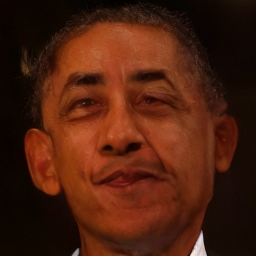

In [3]:
# %%
import torch
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from lora import loraModel

# %%
# 1. Configuration
config_path = "configs/latent-diffusion/celebahq-ldm-vq-4.yaml"
ckpt_path = "celeba/model.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_350.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)

# %%
# 3. Apply your LoRA
old_unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(old_unet, rank=rank, alpha=alpha, qkv=[True, True, True])
unet.set_trainable_parameters()

# Load your trained LoRA state dict
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
missing, unexpected = unet.model.load_state_dict(lora_sd, strict=False)
print(f"LoRA load missing: {len(missing)}, unexpected: {len(unexpected)}")

# quick sanity on LoRA weights
vals = [p.abs().mean().item() for n,p in unet.model.named_parameters() if 'lora_B' in n]
print('LoRA B mean abs (avg):', sum(vals)/len(vals) if vals else None)

model.model.diffusion_model = unet
model.cuda()
# 4. Sampler Setup
sampler = DDIMSampler(model)

# %%
# 5. Generate
# Define parameters
classes = None # Unconditional
n_samples = 1
ddim_steps = 50
ddim_eta = 0.0 # 0 for deterministic, 1 for stochastic
scale = 1.0 # Unconditional guidance scale (doesn't matter much if unconditional)

# Resolution of latents (256px image -> 64x64 latent for f=4 model)
h, w = 256, 256
c = 3
f = 4 # Downsampling factor
shape = [c, h // f, w // f]

with torch.no_grad():
    # Sample from noise
    samples, _ = sampler.sample(
        S=ddim_steps,
        batch_size=n_samples,
        shape=shape,
        eta=ddim_eta,
        verbose=False
    )

    # Decode latents to images
    x_samples_ddim = model.decode_first_stage(samples)

    # Normalize back to [0, 255]
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

    # Convert to image
    x_image_torch = torch.from_numpy(x_samples_ddim).float()
    x_sample = 255. * x_image_torch
    img = x_sample[0].numpy().astype(np.uint8)

    display_img = Image.fromarray(img)
    display_img.save("result_legacy.png")
    display_img.show()

--- Generating Comparison (Seed: 123) ---
1. Sampling with LoRA ENABLED...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


2. Sampling with LoRA DISABLED (Base Model)...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.84it/s]


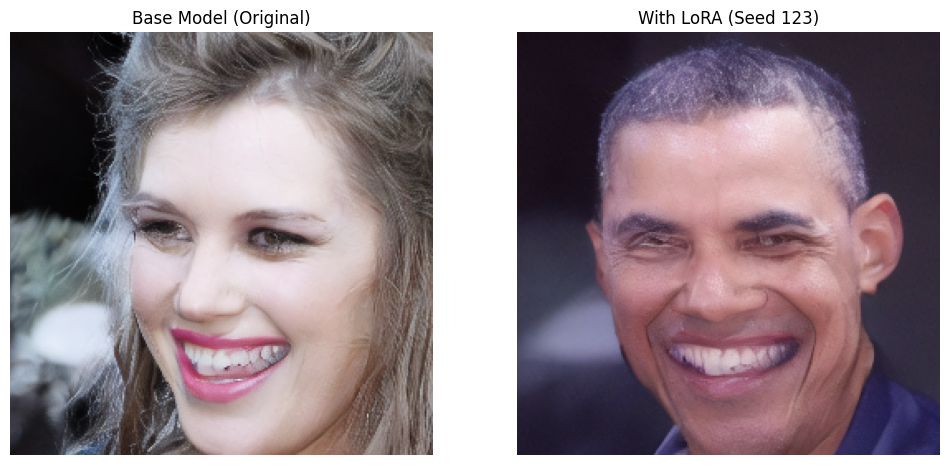

In [4]:
import torch
import numpy as np
from PIL import Image
from einops import rearrange
import matplotlib.pyplot as plt

def generate_comparison(model, sampler, seed=42, steps=50):
    print(f"--- Generating Comparison (Seed: {seed}) ---")

    # 1. Setup Deterministic Noise
    # We create the noise ONCE and pass it to both runs.
    # This ensures the 'randomness' is identical for both.
    generator = torch.Generator(device="cuda").manual_seed(seed)

    # Dimensions for CelebA-HQ 256 (Latent 64x64, 3 channels)
    h, w = 256, 256
    f = 4
    c = 3
    shape = [c, h // f, w // f]

    # Generate the noise tensor on GPU
    # Note: DDIMSampler expects (Batch, Channel, Height, Width)
    x_T = torch.randn((1, *shape), generator=generator, device="cuda")

    # ---------------------------------------------------------
    # RUN 1: LoRA ON
    # ---------------------------------------------------------
    print("1. Sampling with LoRA ENABLED...")

    # LoRA strength relative to original scaling (alpha/rank)
    unet = model.model.diffusion_model

    def set_lora_strength(target_model, strength):
        count = 0
        for module in target_model.modules():
            if hasattr(module, 'scaling'):
                if not hasattr(module, '_original_scaling'):
                    module._original_scaling = module.scaling
                module.scaling = module._original_scaling * strength
                count += 1
        return count

    set_lora_strength(unet, 1.0) # Full LoRA (uses original scaling)

    with torch.no_grad():
        samples_lora, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Pass the fixed noise here
            eta=0.0,
            verbose=False
        )

    # ---------------------------------------------------------
    # RUN 2: LoRA OFF (Base Model)
    # ---------------------------------------------------------
    print("2. Sampling with LoRA DISABLED (Base Model)...")

    # Temporarily set scaling to 0.0 to mute the LoRA layers
    found_layers = set_lora_strength(unet, 0.0)
    if found_layers == 0:
        print("WARNING: Could not find LoRA layers to disable! Comparison might be invalid.")

    with torch.no_grad():
        samples_base, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Reuse the EXACT SAME noise
            eta=0.0,
            verbose=False
        )

    # Restore scaling to 1.0 for future runs
    set_lora_strength(unet, 1.0)

    # ---------------------------------------------------------
    # Decode and Display
    # ---------------------------------------------------------
    def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

    img_lora = decode_img(samples_lora)
    img_base = decode_img(samples_base)

    # Plot Side by Side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img_base)
    ax[0].set_title("Base Model (Original)")
    ax[0].axis('off')

    ax[1].imshow(img_lora)
    ax[1].set_title(f"With LoRA (Seed {seed})")
    ax[1].axis('off')

    plt.show()

# Run the comparison
generate_comparison(model, sampler, seed=123)

Loading model from celeba/model.ckpt
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
trainable params: 1449856 || all params: 275506019 || trainable%: 0.5263
Loading LoRA weights...
LoRA load missing: 368, unexpected: 0
LoRA B Matrices: 128 total
Zero-Initialized: 0 (Should be 0 if loaded correctly!)
Updated LoRA strength to 0.0 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


Updated LoRA strength to 0.25 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


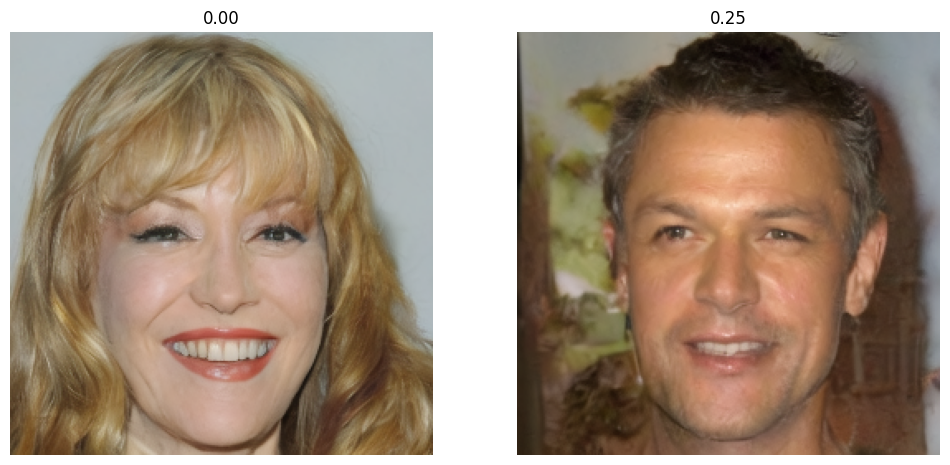

In [5]:
# Run this AFTER you have loaded the model and attached the LoRA

def set_lora_strength(model, strength):
    """
    Manually updates the scaling factor of all LoRA layers.
    strength = 1.0 -> Full LoRA
    strength = 0.5 -> Half strength
    strength = 0.0 -> Original Model
    """
    unet = model.model.diffusion_model
    count = 0

    for module in unet.modules():
        if hasattr(module, "scaling"):
            # Store original scaling if not already stored
            if not hasattr(module, "_original_scaling"):
                module._original_scaling = module.scaling

            # Scale the original value
            module.scaling = module._original_scaling * strength
            count += 1

    print(f"Updated LoRA strength to {strength} for {count} layers.")

# --- TRY THIS ---
# 1. Configuration
config_path = "configs/latent-diffusion/celebahq-ldm-vq-4.yaml"
ckpt_path = "celeba/model.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_300.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)

# %%
# 3. Apply your LoRA
unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(unet, rank=rank, alpha=alpha, qkv=[True, True, True])
unet.set_trainable_parameters()
model.model.diffusion_model = unet

# Load your trained LoRA state dict
# You might need to filter keys if you saved the whole UNet
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
missing, unexpected = unet.model.load_state_dict(lora_sd, strict=False)
print(f"LoRA load missing: {len(missing)}, unexpected: {len(unexpected)}")


# Check if LoRA weights are actually non-zero
def check_lora_weights(model):
    zeros = 0
    total = 0
    for name, param in model.named_parameters():
        if "lora_B" in name:
            total += 1
            if torch.all(param == 0):
                zeros += 1

    print(f"LoRA B Matrices: {total} total")
    print(f"Zero-Initialized: {zeros} (Should be 0 if loaded correctly!)")

    if zeros == total and total > 0:
        print("❌ CRITICAL: Your LoRA weights are all zero. The load_state_dict failed.")
        print("   Solution: Print the keys in lora_sd and model.state_dict() to compare them.")

check_lora_weights(unet)


model.model.diffusion_model = unet
model.cuda()
# 4. Sampler Setup
sampler = DDIMSampler(model)
# 1. Reduce strength to 0.5 or 0.2 to see if distortion disappears
def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

N = 10
img_lora = []
# 2. Run your sampler code again
with torch.no_grad():

  for i in range(2):#N):
    set_lora_strength(model, strength=i/4)
    samples, _ = sampler.sample(S=100, batch_size=1, shape=shape, eta=0.0, verbose=False)
    # ... decode and show image ...

    img_lora.append( decode_img(samples) )

    # Plot Side by Side

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):#N):
  ax[i].imshow(img_lora[i])
  ax[i].set_title(f"{(i/4):.2f}")
  ax[i].axis('off')

plt.show()


In [29]:
import torch
import torch.nn as nn
from typing import Callable, Tuple, Optional
import numpy as np
from tqdm import tqdm


class GaussianProbabilityPath:
    """Gaussian probability path with time-dependent noise schedule."""
    
    def __init__(self, alpha_fn: Callable, sigma_fn: Callable):
        self.alpha_fn = alpha_fn
        self.sigma_fn = sigma_fn
    
    def alpha(self, t: float) -> float:
        return self.alpha_fn(t)
    
    def sigma(self, t: float) -> float:
        return self.sigma_fn(t)
    
    def r_t_squared(self, t: float) -> float:
        """r_t^2 = σ_t^2 / (σ_t^2 + α_t^2)"""
        alpha_t = self.alpha(t)
        sigma_t = self.sigma(t)
        return (sigma_t ** 2) / (sigma_t ** 2 + alpha_t ** 2 + 1e-10)
    
    def d_log_alpha_dt(self, t: float, eps: float = 1e-4) -> float:
        """Compute d ln(α_t) / dt using finite differences"""
        t_plus = min(t + eps, 1.0 - 1e-8)
        t_curr = max(t, 1e-8)
        
        alpha_plus = self.alpha(t_plus)
        alpha_curr = self.alpha(t_curr)
        
        if alpha_curr < 1e-10:
            return 0.0
            
        log_alpha_plus = np.log(max(alpha_plus, 1e-10))
        log_alpha = np.log(max(alpha_curr, 1e-10))
        return (log_alpha_plus - log_alpha) / (t_plus - t_curr)
    
    def d_log_alpha_sigma_dt(self, t: float, eps: float = 1e-4) -> float:
        """Compute d ln(α_t / σ_t) / dt using finite differences"""
        t_plus = min(t + eps, 1.0 - 1e-8)
        t_curr = max(t, 1e-8)
        
        alpha_plus = self.alpha(t_plus)
        sigma_plus = self.sigma(t_plus)
        alpha_curr = self.alpha(t_curr)
        sigma_curr = self.sigma(t_curr)
        
        if sigma_plus < 1e-10 or sigma_curr < 1e-10:
            return 0.0
            
        log_ratio_plus = np.log(max(alpha_plus / sigma_plus, 1e-10))
        log_ratio = np.log(max(alpha_curr / sigma_curr, 1e-10))
        return (log_ratio_plus - log_ratio) / (t_plus - t_curr)


class VariancePreservingPathDDPM(GaussianProbabilityPath):
    """VP path matching DDPM: t ∈ [0, 1] where t=0 is clean, t=1 is noisy"""
    
    def __init__(self, alphas_cumprod: np.ndarray):
        """
        Args:
            alphas_cumprod: The cumulative product of alphas from DDPM model
                           Shape: (num_timesteps,)
        """
        self.alphas_cumprod = alphas_cumprod
        self.num_timesteps = len(alphas_cumprod)
        
        def alpha_fn(t):
            if t <= 0:
                return 1.0
            if t >= 1:
                return np.sqrt(self.alphas_cumprod[-1])
            
            idx = min(int(t * self.num_timesteps), self.num_timesteps - 1)
            return np.sqrt(self.alphas_cumprod[idx])
        
        def sigma_fn(t):
            if t <= 0:
                return 0.0
            if t >= 1:
                return np.sqrt(1.0 - self.alphas_cumprod[-1])
            
            idx = min(int(t * self.num_timesteps), self.num_timesteps - 1)
            return np.sqrt(1.0 - self.alphas_cumprod[idx])
        
        super().__init__(alpha_fn, sigma_fn)
    
    def continuous_t_to_discrete(self, t: float) -> int:
        """Map continuous t ∈ [0,1] to discrete timestep"""
        if t <= 0:
            return 0
        if t >= 1:
            return self.num_timesteps - 1
        return min(int(t * self.num_timesteps), self.num_timesteps - 1)


class ConditionalOTFlowSolver(nn.Module):
    """Solves linear inverse problems via conditional OT flows."""
    
    def __init__(
        self,
        denoiser: Callable,  # Should predict x_0 given (x_t, t)
        measurement_matrix: torch.Tensor,
        probability_path: GaussianProbabilityPath,
        sigma_y: float = 0.0,
        gamma_t: float = 1.0,
        device: str = 'cpu',
        use_jvp: bool = False,
        n_hutchinson_samples: int = 5
    ):
        super().__init__()
        
        if not isinstance(denoiser, nn.Module):
            class FunctionWrapper(nn.Module):
                def __init__(self, fn):
                    super().__init__()
                    self.fn = fn
                def forward(self, *args, **kwargs):
                    return self.fn(*args, **kwargs)
            self.denoiser = FunctionWrapper(denoiser)
        else:
            self.denoiser = denoiser
            
        self.register_buffer('A', measurement_matrix)
        self.probability_path = probability_path
        self.sigma_y = sigma_y
        self.gamma_t = gamma_t
        self.device = device
        self.use_jvp = use_jvp
        self.n_hutchinson_samples = n_hutchinson_samples
        
        # Precompute for efficiency
        self.register_buffer('ATA', self.A.T @ self.A)
        self.register_buffer('AAT', self.A @ self.A.T)
        
    def initialize_xt(
        self,
        y: torch.Tensor,
        t: float,
        shape: Tuple[int, ...]
    ) -> torch.Tensor:
        """Initialize x_t at starting time t"""
        y = y.to(self.device)
        
        # Pseudoinverse initialization
        A_pinv = torch.linalg.pinv(self.A)
        y_lifted = A_pinv @ y
        y_lifted = y_lifted.reshape(shape)
        
        # Add noise according to probability path
        # x_t = α_t * x_0 + σ_t * ε
        alpha_t = self.probability_path.alpha(t)
        sigma_t = self.probability_path.sigma(t)
        
        epsilon = torch.randn(shape, device=self.device, dtype=self.A.dtype)
        z_t = alpha_t * y_lifted + sigma_t * epsilon
        
        return z_t
    
    def compute_probability_flow_velocity(
        self,
        x_t: torch.Tensor,
        x_0_pred: torch.Tensor,
        t: float
    ) -> torch.Tensor:
        """
        Compute probability flow ODE velocity field.
        
        For DDPM with x_t = α_t * x_0 + σ_t * ε:
        The implied noise is: ε = (x_t - α_t * x_0) / σ_t
        
        The probability flow ODE is:
        dx_t/dt = d(α_t)/dt * x_0 + d(σ_t)/dt * ε
        
        Which can also be written as:
        dx_t/dt = [d(α_t)/dt * x_0_pred + d(σ_t)/dt * (x_t - α_t * x_0_pred) / σ_t]
        """
        if t < 1e-5:
            return torch.zeros_like(x_t)
        
        alpha_t = self.probability_path.alpha(t)
        sigma_t = self.probability_path.sigma(t)
        
        # Compute derivatives
        d_alpha_dt = self.probability_path.d_log_alpha_dt(t) * alpha_t
        
        # For DDPM, we have d(σ_t^2)/dt = -d(α_t^2)/dt (variance preserving)
        # So d(σ_t)/dt = -α_t * d(α_t)/dt / σ_t
        if sigma_t > 1e-10:
            d_sigma_dt = -alpha_t * d_alpha_dt / sigma_t
        else:
            d_sigma_dt = 0.0
        
        # Implied noise: ε = (x_t - α_t * x_0) / σ_t
        if sigma_t > 1e-10:
            epsilon_implied = (x_t - alpha_t * x_0_pred) / sigma_t
        else:
            epsilon_implied = torch.zeros_like(x_t)
        
        # Velocity: dx_t/dt = d(α_t)/dt * x_0 + d(σ_t)/dt * ε
        v_t = d_alpha_dt * x_0_pred + d_sigma_dt * epsilon_implied
        
        return v_t
    
    def _flatten_and_unflatten(self, x: torch.Tensor) -> Tuple[torch.Tensor, Tuple[int, ...]]:
        original_shape = x.shape
        flattened = x.reshape(-1)
        return flattened, original_shape
    
    def _compute_grad_via_hutchinson(
        self,
        z_t: torch.Tensor,
        t_discrete: int,
        vector: torch.Tensor,
        original_shape: Tuple[int, ...],
        n_samples: Optional[int] = None
    ) -> torch.Tensor:
        """Compute J^T @ vector using Hutchinson's estimator"""
        if n_samples is None:
            n_samples = self.n_hutchinson_samples
            
        z_t_flat = z_t.reshape(-1)
        n = z_t_flat.shape[0]
        
        with torch.no_grad():
            x_pred_base = self.denoiser(z_t.unsqueeze(0), t_discrete).squeeze(0)
            x_pred_base_flat = x_pred_base.reshape(-1)
        
        grad_estimate = torch.zeros_like(z_t_flat)
        eps = 1e-4
        
        for _ in range(n_samples):
            v = torch.randint(0, 2, (n,), device=self.device, dtype=z_t.dtype) * 2 - 1
            z_perturbed = (z_t_flat + eps * v).reshape(original_shape)
            
            with torch.no_grad():
                x_pred_perturbed = self.denoiser(z_perturbed.unsqueeze(0), t_discrete).squeeze(0)
                x_pred_perturbed_flat = x_pred_perturbed.reshape(-1)
            
            diff = (x_pred_perturbed_flat - x_pred_base_flat) / eps
            grad_estimate += v * torch.dot(diff, vector)
        
        grad_estimate = grad_estimate / n_samples
        return grad_estimate.reshape(original_shape)
    
    def compute_likelihood_gradient(
        self,
        y: torch.Tensor,
        x_pred: torch.Tensor,
        z_t: torch.Tensor,
        t: float,
        t_discrete: int,
        r_t_squared: float
    ) -> torch.Tensor:
        """Compute likelihood gradient ∇_{x_t} ln q(y | x_t)"""
        y = y.to(self.device)
        x_pred_flat, original_shape = self._flatten_and_unflatten(x_pred)
        
        # Residual: y - A x̂_0
        residual = y - self.A @ x_pred_flat
        
        # Covariance matrix
        m = self.A.shape[0]
        covariance = (
            r_t_squared * self.AAT +
            (self.sigma_y ** 2) * torch.eye(m, device=self.device, dtype=self.A.dtype)
        )
        
        # Solve linear system
        inv_cov_residual = torch.linalg.solve(covariance, residual)
        grad_in_measurement_space = self.A.T @ inv_cov_residual
        
        # Apply chain rule through denoiser
        if self.use_jvp:
            try:
                z_t_copy = z_t.clone().detach().requires_grad_(True)
                x_pred_autodiff = self.denoiser(z_t_copy.unsqueeze(0), t_discrete).squeeze(0)
                x_pred_flat_autodiff = x_pred_autodiff.reshape(-1)
                
                grad_likelihood = torch.autograd.grad(
                    outputs=x_pred_flat_autodiff,
                    inputs=z_t_copy,
                    grad_outputs=grad_in_measurement_space,
                    create_graph=False,
                    retain_graph=False
                )[0]
            except:
                grad_likelihood = self._compute_grad_via_hutchinson(
                    z_t, t_discrete, grad_in_measurement_space, original_shape
                )
        else:
            grad_likelihood = self._compute_grad_via_hutchinson(
                z_t, t_discrete, grad_in_measurement_space, original_shape
            )
        
        return grad_likelihood
    
    def correct_vector_field_theorem1(
        self,
        v_hat: torch.Tensor,
        likelihood_grad: torch.Tensor,
        t: float
    ) -> torch.Tensor:
        """Apply Theorem 1 correction"""
        sigma_t = self.probability_path.sigma(t)
        d_log_ratio_dt = self.probability_path.d_log_alpha_sigma_dt(t)
        
        correction = (sigma_t ** 2) * d_log_ratio_dt * self.gamma_t * likelihood_grad
        v_corrected = v_hat + correction
        
        return v_corrected
    
    def forward(
        self,
        y: torch.Tensor,
        signal_shape: Tuple[int, ...],
        t_start: float = 0.95,
        t_end: float = 0.01,
        n_steps: int = 50,
        use_likelihood_correction: bool = True,
        use_ddim: bool = False  # Add option for DDIM-style deterministic sampling
    ) -> torch.Tensor:
        """
        Solve inverse problem by integrating ODE from t_start (noisy) to t_end (clean).
        """
        # Initialize at high noise
        z_t = self.initialize_xt(y, t_start, signal_shape)
        
        # Time schedule
        t_schedule = torch.linspace(t_start, t_end, n_steps, device=self.device)
        
        pbar = tqdm(range(len(t_schedule) - 1), desc="ODE Integration")
        for i in pbar:
            t_current = float(t_schedule[i])
            t_next = float(t_schedule[i + 1])
            dt = t_next - t_current  # Negative (going toward 0)
            
            # Map to discrete timestep
            if hasattr(self.probability_path, 'continuous_t_to_discrete'):
                t_discrete = self.probability_path.continuous_t_to_discrete(t_current)
            else:
                t_discrete = max(0, int(t_current * 1000))
            
            # Get x_0 prediction from denoiser
            with torch.no_grad():
                x_0_pred = self.denoiser(z_t.unsqueeze(0), t_discrete).squeeze(0)
            
            if use_ddim:
                # DDIM-style update: x_{t-dt} = α_{t-dt} * x_0 + σ_{t-dt} * ε
                alpha_next = self.probability_path.alpha(t_next)
                sigma_next = self.probability_path.sigma(t_next)
                
                # Implied noise
                alpha_current = self.probability_path.alpha(t_current)
                sigma_current = self.probability_path.sigma(t_current)
                
                if sigma_current > 1e-10:
                    epsilon_implied = (z_t - alpha_current * x_0_pred) / sigma_current
                else:
                    epsilon_implied = torch.zeros_like(z_t)
                
                # Direct update
                z_t_next = alpha_next * x_0_pred + sigma_next * epsilon_implied
                
                if use_likelihood_correction and self.gamma_t > 0 and t_current > 0.1:
                    r_t_squared = self.probability_path.r_t_squared(t_current)
                    likelihood_grad = self.compute_likelihood_gradient(
                        y, x_0_pred, z_t, t_current, t_discrete, r_t_squared
                    )
                    
                    # Apply correction (scaled by dt for consistency)
                    sigma_t = self.probability_path.sigma(t_current)
                    d_log_ratio_dt = self.probability_path.d_log_alpha_sigma_dt(t_current)
                    correction = (sigma_t ** 2) * d_log_ratio_dt * self.gamma_t * likelihood_grad * abs(dt)
                    
                    z_t_next = z_t_next + correction
                
                z_t = z_t_next
            else:
                # ODE-style update using velocity field
                v_unconditional = self.compute_probability_flow_velocity(z_t, x_0_pred, t_current)
                
                # Apply likelihood correction
                if use_likelihood_correction and self.gamma_t > 0 and t_current > 0.1:
                    r_t_squared = self.probability_path.r_t_squared(t_current)
                    likelihood_grad = self.compute_likelihood_gradient(
                        y, x_0_pred, z_t, t_current, t_discrete, r_t_squared
                    )
                    v_corrected = self.correct_vector_field_theorem1(
                        v_unconditional, likelihood_grad, t_current
                    )
                else:
                    v_corrected = v_unconditional
                
                # Euler step
                z_t = z_t + v_corrected * dt
            
            pbar.set_postfix({
                't': f'{t_current:.3f}', 
                'mean': f'{z_t.mean():.3f}', 
                'std': f'{z_t.std():.3f}',
                'x0_std': f'{x_0_pred.std():.3f}'
            })
            
            if i % 10 == 0:
                torch.cuda.empty_cache()
        
        return z_t


# ========== CORRECT DENOISER FOR COMPVIS LATENT DIFFUSION ==========

def create_compvis_denoiser(model):
    """
    Create a proper x_0 predictor from CompVis LDM model.
    
    The model.apply_model() predicts NOISE (ε), so we need to convert:
    x_0 = (x_t - sqrt(1 - ᾱ_t) * ε) / sqrt(ᾱ_t)
    """
    
    # Extract DDPM parameters from model
    if hasattr(model, 'alphas_cumprod'):
        alphas_cumprod = model.alphas_cumprod.cpu().numpy()
    elif hasattr(model, 'betas'):
        betas = model.betas.cpu().numpy()
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas)
    else:
        raise ValueError("Cannot extract alpha schedule from model")
    
    sqrt_alphas_cumprod = torch.from_numpy(np.sqrt(alphas_cumprod)).float().to(model.device)
    sqrt_one_minus_alphas_cumprod = torch.from_numpy(np.sqrt(1.0 - alphas_cumprod)).float().to(model.device)
    
    def denoiser(x_t: torch.Tensor, t: int) -> torch.Tensor:
        """
        Predict x_0 from x_t at timestep t.
        
        Args:
            x_t: Noisy latent, shape (batch, channels, h, w)
            t: Timestep index (int)
        
        Returns:
            x_0: Predicted clean latent
        """
        batch_size = x_t.shape[0]
        
        # Create timestep tensor
        if isinstance(t, int):
            t_tensor = torch.full((batch_size,), t, device=x_t.device, dtype=torch.long)
        else:
            t_tensor = torch.tensor([t] * batch_size, device=x_t.device, dtype=torch.long)
        
        # Ensure t is in valid range
        t_tensor = torch.clamp(t_tensor, 0, len(alphas_cumprod) - 1)
        
        # Predict noise using the model
        with torch.no_grad():
            if hasattr(model, 'apply_model'):
                eps_pred = model.apply_model(x_t, t_tensor, None)
            elif hasattr(model, 'model'):
                eps_pred = model.model(x_t, t_tensor, None)
            else:
                raise ValueError("Cannot find model prediction method")
        
        # Convert noise prediction to x_0 prediction
        sqrt_alpha_t = sqrt_alphas_cumprod[t_tensor].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_t = sqrt_one_minus_alphas_cumprod[t_tensor].view(-1, 1, 1, 1)
        
        x_0_pred = (x_t - sqrt_one_minus_alpha_t * eps_pred) / (sqrt_alpha_t + 1e-8)
        
        return x_0_pred
    
    return denoiser, alphas_cumprod


# ========== USAGE ==========

def solve_inverse_problem(model, y, A, signal_shape=(3, 64, 64), device='cuda', 
                          gamma_t=0.5, n_steps=50, use_ddim=False):
    """
    Complete pipeline to solve inverse problem.
    
    Args:
        model: CompVis LatentDiffusionModel
        y: Measurements (1D tensor)
        A: Measurement matrix
        signal_shape: Shape of signal in latent space
        device: 'cuda' or 'cpu'
        gamma_t: Strength of likelihood correction
        n_steps: Number of integration steps
        use_ddim: Use DDIM-style updates instead of ODE integration
    
    Returns:
        x_reconstructed: Reconstructed latent
    """
    
    # Create proper denoiser
    denoiser, alphas_cumprod = create_compvis_denoiser(model)
    
    # Create probability path matching the model
    prob_path = VariancePreservingPathDDPM(alphas_cumprod)
    
    # Create solver
    solver = ConditionalOTFlowSolver(
        denoiser=denoiser,
        measurement_matrix=A,
        probability_path=prob_path,
        sigma_y=0.01,
        gamma_t=gamma_t,
        device=device,
        use_jvp=False,
        n_hutchinson_samples=50
    )
    
    # Solve
    x_reconstructed = solver(
        y,
        signal_shape=signal_shape,
        t_start=0.95,
        t_end=0.01,
        n_steps=n_steps,
        use_likelihood_correction=(gamma_t > 0),
        use_ddim=use_ddim
    )
    
    return x_reconstructed
"""

# Configuration 1: DDIM-style (most stable)
x_reconstructed = solve_inverse_problem(
    model=model,
    y=measurement,
    A=A,
    signal_shape=(3, 64, 64),
    device='cuda',
    gamma_t=0.0,
    n_steps=100,  # More steps for stability
    use_ddim=True  # Use DDIM updates
)



# Configuration 2: ODE with more steps
x_reconstructed = solve_inverse_problem(
    model=model,
    y=measurement,
    A=A,
    signal_shape=(3, 64, 64),
    device='cuda',
    gamma_t=0.0,
    n_steps=200,  # Many more steps
    use_ddim=False  # Use ODE
)
"""
# Configuration 3: With correction
x_reconstructed = solve_inverse_problem(
    model=model,
    y=measurement,
    A=A,
    signal_shape=(3, 64, 64),
    device='cuda',
    gamma_t=0.5,
    n_steps=100,
    use_ddim=True
)



ODE Integration: 100%|██████████| 99/99 [06:15<00:00,  3.79s/it, t=0.019, mean=129.489, std=13127.689, x0_std=13228.729]


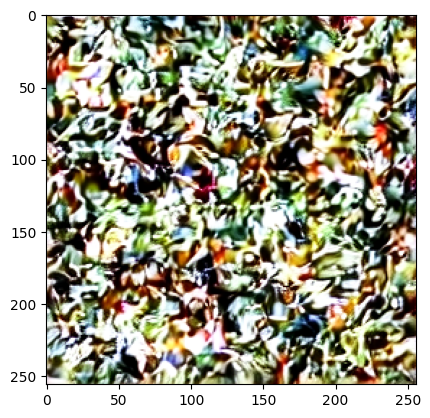

In [30]:

plt.imshow(decode_img(x_reconstructed.unsqueeze(0)))
plt.show()